In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
#import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np 
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm


c:\bachelor47\gruppe47\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)


In [4]:
notebook_path = os.path.abspath("selvtrent.ipynb")

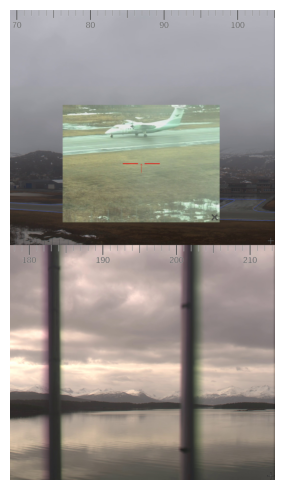

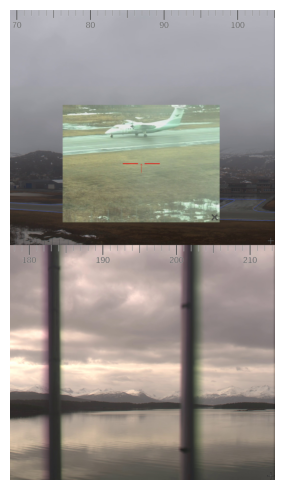

In [5]:
filepath = os.path.join(os.path.dirname(notebook_path), "frames/116.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)


In [6]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)


In [7]:
image_batch = inference_resizing([image])


In [8]:
BATCH_SIZE = 4

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "DiningTable",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "PottedPlant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


In [9]:
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    
    return ds

In [10]:
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


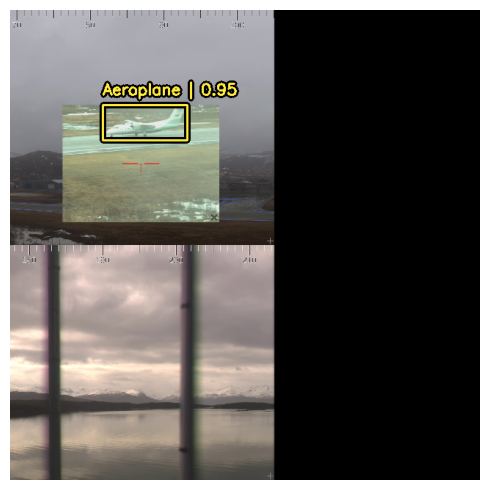

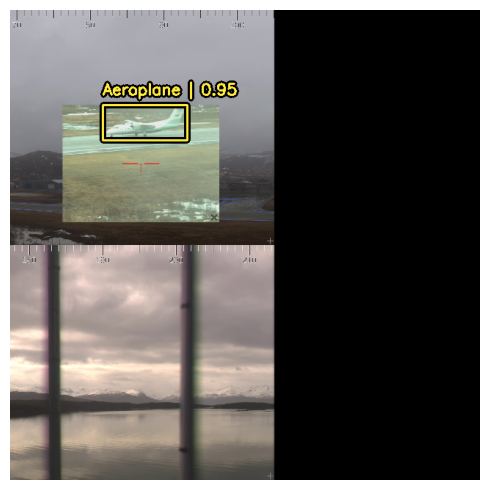

In [11]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


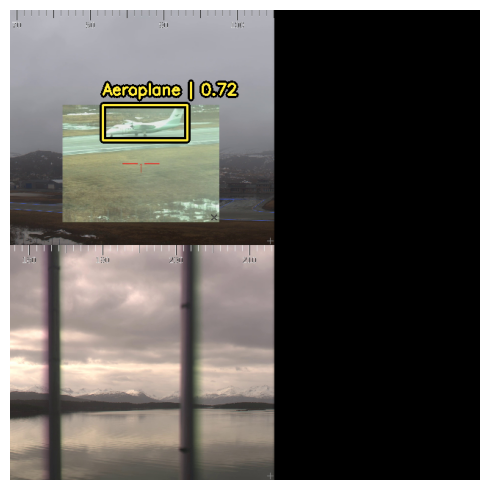

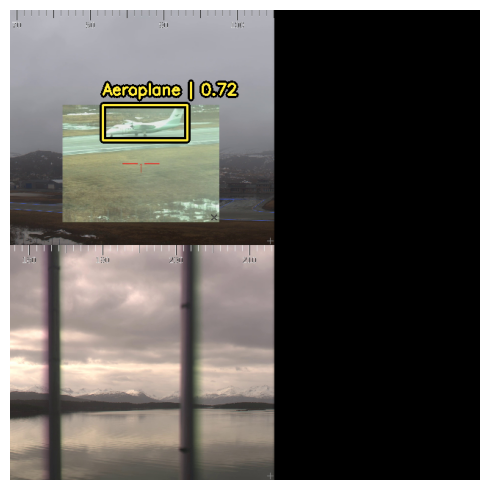

In [12]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


In [13]:
retina_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc",
    num_classes=20,
    bounding_box_format="xywh",
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step


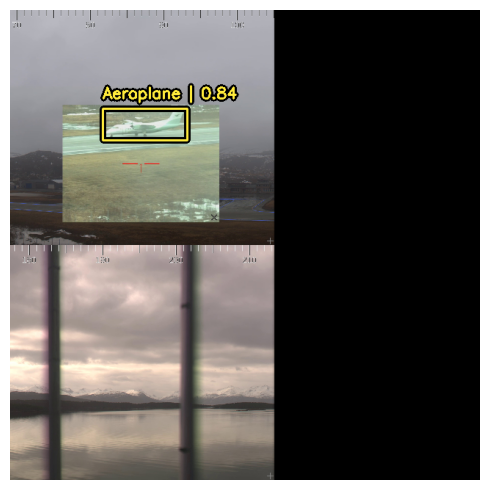

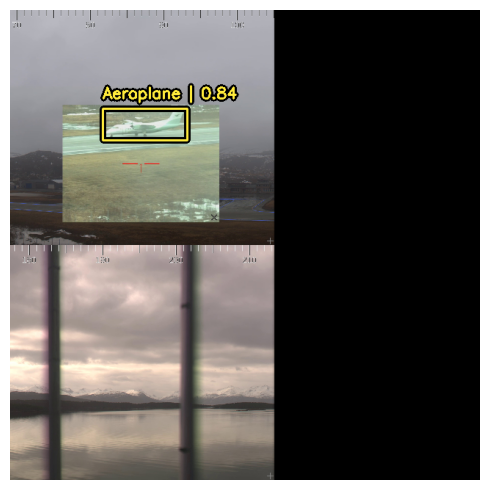

In [14]:
y_pred = retina_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


In [15]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

In [16]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

In [17]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )



eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)


eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

base_lr = 0.005

optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [18]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [19]:
#evaluation_result = pretrained_model.evaluate(eval_ds.take(100))

In [20]:
retina_model.compile(
    optimizer=optimizer,
    box_loss="SmoothL1",
)


In [21]:
#evaluation_result = retina_model.evaluate(eval_ds.take(100))

In [22]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [45]:
iterabledata = iter(visualization_ds.take(2))
for z in range(2):

    input_data, truey = next(iterabledata)
    y_pred = pretrained_model.predict(input_data)
    for y in range(len(truey['classes'])):

        image_filename = f'images/image_{y+z*16}.txt'
        pred_filename = f'preds/image_{y+z*16}.txt'
        imageclass = np.array(truey['classes'][y])
        imagebox = np.array(truey['boxes'][y])

        predictedclass = np.array(y_pred['classes'][y])
        predbox = np.array(y_pred['boxes'][y])

        namedclasses = [0]*len(imageclass)
        namedpredictedclasses = [0]*len(predictedclass)

        conf = np.array(y_pred['confidence'][0])

        for x in range(len(imageclass)):
            namedclasses[x] = class_ids[int(imageclass[x])]
        
        for x in range(len(predictedclass)):
            namedpredictedclasses[x] = class_ids[int(predictedclass[x])]

        with open (image_filename, 'w') as f:
            for x in range(len(namedclasses)):
                if namedclasses[x] != 'Total':
                    f.write(f"{namedclasses[x]} {int(imagebox[x][0])} {int(imagebox[x][1])} {int(imagebox[x][2])} {int(imagebox[x][3])} \n")

        with open (pred_filename, 'w') as f2:            
            for x in range(len(namedpredictedclasses)):
                if namedpredictedclasses[x] != 'Total':
                    f2.write(f"{namedpredictedclasses[x]} {conf[x]} {int(predbox[x][0])} {int(predbox[x][1])} {int(predbox[x][2])} {int(predbox[x][3])} \n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [48]:
iterabledata = iter(visualization_ds.take(2))
for z in range(2):

    input_data, truey = next(iterabledata)
    y_pred = retina_model.predict(input_data)
    for y in range(len(truey['classes'])):

        image_filename = f'retground/image_{y+z*16}.txt'
        pred_filename = f'retpred/image_{y+z*16}.txt'
        imageclass = np.array(truey['classes'][y])
        imagebox = np.array(truey['boxes'][y])

        predictedclass = np.array(y_pred['classes'][y])
        predbox = np.array(y_pred['boxes'][y])

        namedclasses = [0]*len(imageclass)
        namedpredictedclasses = [0]*len(predictedclass)

        conf = np.array(y_pred['confidence'][0])

        for x in range(len(imageclass)):
            namedclasses[x] = class_ids[int(imageclass[x])]
        
        for x in range(len(predictedclass)):
            namedpredictedclasses[x] = class_ids[int(predictedclass[x])]

        with open (image_filename, 'w') as f:
            for x in range(len(namedclasses)):
                if namedclasses[x] != 'Total':
                    f.write(f"{namedclasses[x]} {int(imagebox[x][0])} {int(imagebox[x][1])} {int(imagebox[x][2])} {int(imagebox[x][3])} \n")

        with open (pred_filename, 'w') as f2:            
            for x in range(len(namedpredictedclasses)):
                if namedpredictedclasses[x] != 'Total':
                    f2.write(f"{namedpredictedclasses[x]} {conf[x]} {int(predbox[x][0])} {int(predbox[x][1])} {int(predbox[x][2])} {int(predbox[x][3])} \n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 571s 571s/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 500s 500s/step
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
